# PyTorch LSTM Tutorial (nicht lineares Problem)
https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-networks-using-pytorch/

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1) Datensatz erzeugen (Sinus)

In [2]:
steps = 1200
t     = np.linspace(0, 40, steps, dtype=np.float32)
x1    = np.sin(t)                  # Feature 1  (σ   --> analog)
x2    = np.cos(0.7*t + 1)          # Feature 2  (ε   --> analog)
y     = x1 * (x2 + 0.5)            # nicht-lineare Kombination (Δσ)

seq_len = 25                       # Lookback
def make_seq(a, b, y, L):
    X, Y = [], []
    for i in range(len(y)-L):
        X.append(np.stack([a[i:i+L], b[i:i+L]], axis=1))  # (L,2)
        Y.append(y[i+L])
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
    return X, Y

X, Y = make_seq(x1, x2, y, seq_len)
print(X.shape, Y.shape)            # (samples, L, 2) / (samples,1)

torch.Size([1175, 25, 2]) torch.Size([1175, 1])


C:\Users\lukas\AppData\Local\Temp\ipykernel_21620\3784474042.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  X = torch.tensor(X, dtype=torch.float32)


# 2) LSTM-Modell definieren

In [3]:
class NonLinearLSTM(nn.Module):
    def __init__(self, in_dim=2, h_dim=64, layers=2):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, h_dim, layers, batch_first=True)
        self.head = nn.Sequential(
            nn.ReLU(),           # Non-Linärität
            nn.Linear(h_dim,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self, x, hc=None):
        out, hc = self.lstm(x, hc)      # out: (B,L,h_dim)
        out     = self.head(out[:,-1])  # letztes Zeitschritt
        return out, hc

# 3) Training

In [4]:
model = NonLinearLSTM()
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 250
hc = None
for ep in range(1, epochs+1):
    model.train(); optimiser.zero_grad()
    pred, hc = model(X, hc)
    loss = criterion(pred, Y)
    loss.backward(); optimiser.step()
    hc = tuple(h.detach() for h in hc)   # <-- wichtig!
    if ep % 25 == 0:
        print(f"Epoch {ep:3d} | loss {loss.item():.6f}")

Epoch  25 | loss 0.216958
Epoch  50 | loss 0.070601
Epoch  75 | loss 0.018860
Epoch 100 | loss 0.008091
Epoch 125 | loss 0.002337
Epoch 150 | loss 0.001200
Epoch 175 | loss 0.000810
Epoch 200 | loss 0.000709
Epoch 225 | loss 0.000552
Epoch 250 | loss 0.000343


In [5]:
# 4) Vorhersage & Plot

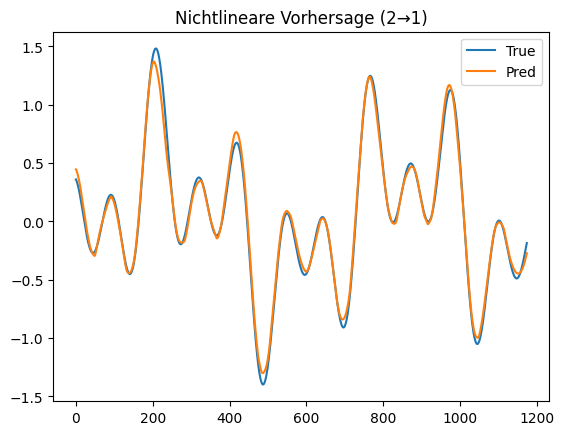

In [6]:
model.eval()
with torch.no_grad():
    y_hat, _ = model(X)
y_hat = y_hat.squeeze().numpy()

import matplotlib.pyplot as plt
plt.plot(y[seq_len:], label="True")
plt.plot(y_hat,       label="Pred")
plt.title("Nichtlineare Vorhersage (2→1)")
plt.legend(); plt.show()